# Refitting a PLOG into a TROE
1. First step compute the value of the kinetic constant of the PLOG across the ranges of pressure and temperature desired.
2. Compute first guess values for the TROE kinetic constant formalism, we will need the three arrhenius parameters both for the High pressure and low pressure limits and the four parameters of the TROE fitting formalism.
3. Run the optimization.
4. Finally evaluate the refitted constant by visual comparison, different plots are provided down below.

Keep in mind that providing already a reasonable first guess is crucial for the success of the refitting.

In [1]:
import os
import sys
from functools import partial

# Matplotlib and scipy
import matplotlib.pyplot as plt

# JAX stuff
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# NLOPT python API
sys.path.append("/Users/tdinelli/NumericalLibraries/nlopt/nlopt-2.7.1-clang-18.1.7/lib/python3.12/site-packages")
import nlopt

# Internal modules
current_file_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_file_dir, ".."))
sys.path.append(module_path)
from diffPLOG2TROE.falloff import compute_falloff, kinetic_constant_falloff
from diffPLOG2TROE.pressure_logarithmic import compute_plog, kinetic_constant_plog
from diffPLOG2TROE.refitter import rmse_loss_function, compute_pressure_limits, nlopt_loss

# Visualization

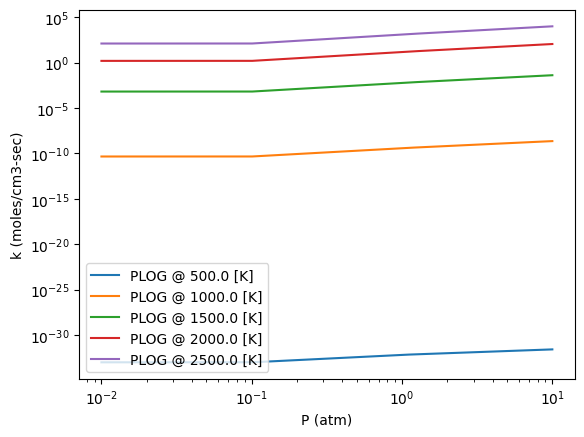

In [2]:
constant_plog = jnp.array([
    [1.00E-01, 7.23E+29, -5.32E+00, 110862.4],
    [1.00E+00, 3.50E+30, -5.22E+00, 111163.3],
    [1.00E+01, 1.98E+31, -5.16E+00, 111887.8],
    [1.00E+02, 2.69E+31, -4.92E+00, 112778.7],
], dtype=jnp.float64)

T = jnp.array([500, 1000, 1500, 2000, 2500], dtype=jnp.float64)  # Obv these are dummy values :)
P = jnp.logspace(-2, 1 , 300, dtype=jnp.float64)

for t in T:
    kc = compute_plog(constant_plog, jnp.array([t]), P)
    plt.plot(P, kc, "-", label=f"PLOG @ {t} [K]")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("P (atm)")
plt.ylabel("k (moles/cm3-sec)")
plt.legend()
plt.show()

In [3]:
T_range = jnp.logspace(2.5, 3.4, 50)
P_range = jnp.logspace(-1, 2, 50)

print(f"Temperature range -> {T_range[0]} - {T_range[-1]}")
print(f"Pressure range    -> {P_range[0]} - {P_range[-1]}")

k_plog = compute_plog(constant_plog, T_range, P_range)

pressure_limits_fg = compute_pressure_limits(constant_plog, T_range, P_range)

fg = jnp.array([
    jnp.log(pressure_limits_fg[3]), pressure_limits_fg[4], pressure_limits_fg[5]/1.987, # HPL
    jnp.log(pressure_limits_fg[0]), pressure_limits_fg[1], pressure_limits_fg[2]/1.987, # LPL
    10.0,    100.0,   1e+30, 1e+30
], dtype=jnp.float64)
data = (T_range, P_range, k_plog)
bounds = [
    (jnp.log(pressure_limits_fg[3]) - 5, jnp.log(pressure_limits_fg[3]) + 5),
    (pressure_limits_fg[4] - 3, pressure_limits_fg[4] + 3),
    (pressure_limits_fg[5] / 1.987 - 20000, pressure_limits_fg[5] / 1.987 + 20000),
    (jnp.log(pressure_limits_fg[0]) - 5, jnp.log(pressure_limits_fg[0]) + 5),
    (pressure_limits_fg[1] - 3, pressure_limits_fg[1] + 3),
    (pressure_limits_fg[2] / 1.987 - 20000, pressure_limits_fg[2] / 1.987 + 20000),
    (1e-2, 1e5),
    (1e-5, 1e5),
    (1, 1e30),
    (1, 1e30),
]

Temperature range -> 316.22776601683796 - 2511.88643150958
Pressure range    -> 0.1 - 100.0
 Computing first guesses for the LPL and HPL
  * Adjusted R2 for the LPL: 1.0
    - A: 7.2299875e+29, b: -5.32, Ea: 1.1086240e+05
  * Adjusted R2 for the HPL: 1.0
    - A: 2.6899955e+31, b: -4.92, Ea: 1.1277870e+05



In [4]:
%%time
print(fg)
print(rmse_loss_function(fg, data))
iter_count = [0]
lbs = [float(i[0]) for i in bounds]
ubs = [float(i[1]) for i in bounds]

# opt = nlopt.opt(nlopt.GN_DIRECT_L, len(fg))
# opt = nlopt.opt(nlopt.GN_ESCH, len(fg))
opt = nlopt.opt(nlopt.GN_ISRES, len(fg))

opt.set_lower_bounds(lbs)
opt.set_upper_bounds(ubs)
opt.set_xtol_rel(1e-10) 
opt.set_ftol_rel(1e-10)
opt.set_maxeval(10000000)

opt.set_min_objective(partial(nlopt_loss, data=data, iteration_count=iter_count))
final_params = opt.optimize(fg)
minf = opt.last_optimum_value()

print("result code = ", opt.last_optimize_result())

[ 7.23696774e+01 -5.91999979e+00  5.67582786e+04  6.87532050e+01
 -6.31999978e+00  5.57938599e+04  1.00000000e+01  1.00000000e+02
  1.00000000e+30  1.00000000e+30]
49.999999184513996
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 4.9996145190E+01
Loss = 4.9999998447E+01
Loss = 7.0482938802E+02
Loss = 4.9999976473E+01
Loss = 1.7425729417E+02
Loss = 4.9999999994E+01
Loss = 4.9999996547E+01
Loss = 1.6575415629E+10
Loss = 4.9851543557E+01
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 4.9999981019E+01
Loss = 4.9999999999E+01
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 4.9999492753E+01
Loss = 4.9999979375E+01
Loss = 4.9998241743E+01
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 5.0000000000E+01
Loss = 4.9999997818E+01
Loss = 4.9999999962E+01
Loss = 4.8931951097E+01
Loss = 4.9999929601E+01
Loss = 4.9999803187E+01
Loss = 5.0000000000E+01
Loss = 4.9999995123E+01
Loss = 4.9846747522E+01
Loss = 4.9999999932E+01
L

In [5]:
refitted_troe = (
    jnp.array([
        [jnp.exp(final_params[0]), final_params[1], final_params[2]*1.987, 0.000],  # HPL, the fourth term is dummy
        [jnp.exp(final_params[3]), final_params[4], final_params[5]*1.987, 0.000],  # LPL, the fourth term is dummy
        [final_params[6], final_params[7], final_params[8], final_params[9]],  # TROE parameters
    ], dtype=jnp.float64),
    1, # Lindemann -> 0, TROE -> 1, SRI -> 2
)
k_refitted = compute_falloff(refitted_troe, T_range, P_range)

print(refitted_troe)

(Array([[ 1.81251105e+29, -3.89758420e+00,  1.13173796e+05,
         0.00000000e+00],
       [ 7.88887705e+31, -4.03306453e+00,  1.10204857e+05,
         0.00000000e+00],
       [ 2.78681417e-01,  1.67212868e+02,  9.17390726e+29,
         9.33322951e+29]], dtype=float64), 1)


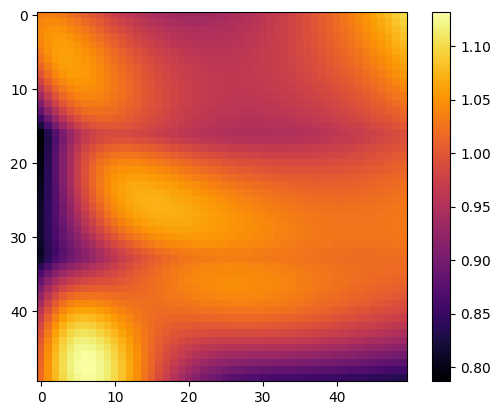

In [6]:
ratio = k_refitted / k_plog
fig, ax = plt.subplots()

c = ax.imshow(ratio, cmap='inferno', interpolation='nearest')
fig.colorbar(c, ax=ax)

plt.show()